## Support Vector Machine Kernels

#### Vincent Indina
#### Petroleum and Geosystems Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Lei Liu, Graduate Student, The University of Texas at Austin

### Import Packages
The following are python packages needed in this workflow. The main package that we used is 'sklearn'.

In [1]:
import numpy as np                                          # for working with data and model arrays
import matplotlib.pyplot as plt                             # for plotting and visualizing data and models
import pandas as pd                                         # for organizing data
#import os                                                   # need to organize, set current directory
import seaborn as sns                                       # for data visualization of synthetic dataset
from sklearn.svm import SVC                                 # used for support vector machine classifier methods
from sklearn.model_selection import train_test_split        # split into training and testing datasets
from sklearn.metrics import confusion_matrix                # for sumarizing model performance
from sklearn.preprocessing import StandardScaler            #used for scaling data to train a model 
from sklearn.model_selection import StratifiedShuffleSplit  # used for tuning hyperparameters
from sklearn.model_selection import GridSearchCV            # used for tuning hyperparameters
from sklearn.model_selection import cross_val_score
scaler = StandardScaler()                                   # instantiate a standard scaler for use later
cmap = plt.cm.RdYlBu
import warnings                                             # ignore warnings
warnings.filterwarnings('ignore')

### Functions
The following functions will be used in the workflow. These functions are taken from Dr. Michael Pyrcz, SubSurfuceDataAnalytics_SupportVectorMachines.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_SupportVectorMachines.ipynb).

In [2]:
def plot_corr(dataframe,size=10):                               # plots a graphical correlation matrix 
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0,cmap=cmap)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')
def visualize_model(model,nxfeature,nyfeature,xfeature,yfeature,response):# plots the data points and the decision tree prediction 
    n_classes = 10
    cmap = plt.cm.RdYlBu
    x_min, x_max = min(nxfeature)-1, max(nxfeature)+1 
    y_min, y_max = min(nyfeature)-1 , max(nyfeature)+1
    #y_min,y_max = 'low','high'
    plot_step = 100
    resp_min = round(min(response)); resp_max = round(max(response));
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, plot_step),
                     np.linspace(y_min, y_max, plot_step))
    
    z_min = round(min(response)); z_max = round(max(response))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    trans = scaler.inverse_transform(np.c_[xx.ravel(), yy.ravel()])
    trans_x = trans[:,0].reshape(xx.shape)
    trans_y = trans[:,1].reshape(xx.shape)
    
    cs = plt.contourf(trans_x, trans_y, Z, vmin=z_min, vmax=z_max)

    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None,  norm=None, vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3, edgecolors="black")
    plt.xlabel(xfeature.name)
    plt.ylabel(yfeature.name)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(response.name, rotation=270, labelpad=20)
    return(plt)

def plot_svc_decision_function(model,plt, plot_support=True): # modified from Jake VanderPlas's Python Data Science Handbook  
    """Plot the decision function for a 2D SVC"""
    xlim = [-2.5,15]
    ylim = [-2.5,7]
    # plot support vectors
    sv = scaler.inverse_transform(model.support_vectors_)
    if plot_support:
        plt.scatter(sv[:, 0],
                   sv[:, 1],
                   s=3, linewidth=8,alpha = 0.6, facecolors='black');
#Functions from Professor Michael Pyrcz, https://github.com/GeostatGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_SVM.ipynb
        

### Load Data

The following workflow applies the .csv file 'bankloans.csv', an open dataset about banking customer debts and loans information by Atul Mittal. The dataset is publicly avaliable [here](https://www.kaggle.com/datasets/atulmittal199174/credit-risk-analysis-for-extending-bank-loans)

We will work with the following features:

* **employ** - customer's work experience $years$
* **debtinc** - customer's debt to income ratio
* **default** - customer's default history (0: never defaulted, 1: defaulted)

In [3]:
url = "https://raw.githubusercontent.com/vincentidn/bankloans/main/bankloans.csv"

# Read CSV data into a pandas DataFrame
df = pd.read_csv(url)

df.head(10)

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0
5,41,2,5,5,25,10.2,0.392700,2.157300,0.0
6,39,1,20,9,67,30.6,3.833874,16.668126,0.0
7,43,1,12,11,38,3.6,0.128592,1.239408,0.0
8,24,1,3,4,19,24.4,1.358348,3.277652,1.0
9,36,1,0,13,25,19.7,2.777700,2.147300,0.0


In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,1150.0,35.235652,8.089961,20.000000,29.000000,35.000000,41.00000,56.00000
ed,1150.0,1.695652,0.927051,1.000000,1.000000,1.000000,2.00000,5.00000
employ,1150.0,8.781739,6.914762,0.000000,3.000000,7.000000,13.00000,33.00000
address,1150.0,8.485217,6.977725,0.000000,3.000000,7.000000,12.00000,34.00000
income,1150.0,47.982609,40.508814,13.000000,24.000000,36.000000,56.75000,446.00000
debtinc,1150.0,10.063391,6.584288,0.100000,5.200000,8.750000,13.60000,41.30000
creddebt,1150.0,1.605111,2.135967,0.011696,0.415584,0.899130,1.89882,20.56131
othdebt,1150.0,3.103844,3.529273,0.045584,1.047996,2.038053,3.86496,35.19750
default,700.0,0.261429,0.439727,0.000000,0.000000,0.000000,1.00000,1.00000


# Impact of Support Vector Machine Kernels to Model Performance

### Executive Summary
In this project, we aim to investigate how different support vector machine kernels (linear and polynomial) impact model performance. The project consists of two main parts: fitting the data to different support vector machine kernels and determining the most suitable kernel for subsequent use in the analysis of model performance. To assess model performance, we employed k-fold cross-validation.

### 1. Checking Dataset and Drop Missing Values
Feature 'default' has missing values. To resolve the missing value issue, we deleted data rows with missing values. We didn't perform feature imputation becasue it requires deeper domain knowledge about banking to decide whether a customer will be defaulted or not.

In [5]:
#removing nans from the dataframe
df=df.dropna()
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,700.0,34.860000,7.997342,20.000000,29.000000,34.000000,40.000000,56.00000
ed,700.0,1.722857,0.928206,1.000000,1.000000,1.000000,2.000000,5.00000
employ,700.0,8.388571,6.658039,0.000000,3.000000,7.000000,12.000000,31.00000
address,700.0,8.278571,6.824877,0.000000,3.000000,7.000000,12.000000,34.00000
income,700.0,45.601429,36.814226,14.000000,24.000000,34.000000,55.000000,446.00000
debtinc,700.0,10.260571,6.827234,0.400000,5.000000,8.600000,14.125000,41.30000
creddebt,700.0,1.553553,2.117197,0.011696,0.369059,0.854869,1.901955,20.56131
othdebt,700.0,3.058209,3.287555,0.045584,1.044178,1.987567,3.923065,27.03360
default,700.0,0.261429,0.439727,0.000000,0.000000,0.000000,1.000000,1.00000


### 2. Plot Correlation Matrix and Features Selection
In this section, we plotted the correlation matrix of predictor features against the response feature 'default'. The objective of this section is to determine which predictor features are correlated to the response feature. We found that predictor features 'employ' and 'debtinc' are correlated to response feature 'default'. Moreover, these two predictor features logically make sense to influence the tendency of customers to be defaulted in their credit/loan payments.

In [6]:
corr_matrix = np.corrcoef(df, rowvar = False)  # correlation matrix without the categorical value
print(np.around(corr_matrix,2)) 

[[ 1.    0.02  0.54  0.6   0.48  0.02  0.3   0.34 -0.14]
 [ 0.02  1.   -0.15  0.06  0.24  0.01  0.09  0.17  0.11]
 [ 0.54 -0.15  1.    0.32  0.62 -0.03  0.4   0.41 -0.28]
 [ 0.6   0.06  0.32  1.    0.32  0.01  0.21  0.23 -0.16]
 [ 0.48  0.24  0.62  0.32  1.   -0.03  0.57  0.61 -0.07]
 [ 0.02  0.01 -0.03  0.01 -0.03  1.    0.5   0.58  0.39]
 [ 0.3   0.09  0.4   0.21  0.57  0.5   1.    0.63  0.24]
 [ 0.34  0.17  0.41  0.23  0.61  0.58  0.63  1.    0.15]
 [-0.14  0.11 -0.28 -0.16 -0.07  0.39  0.24  0.15  1.  ]]


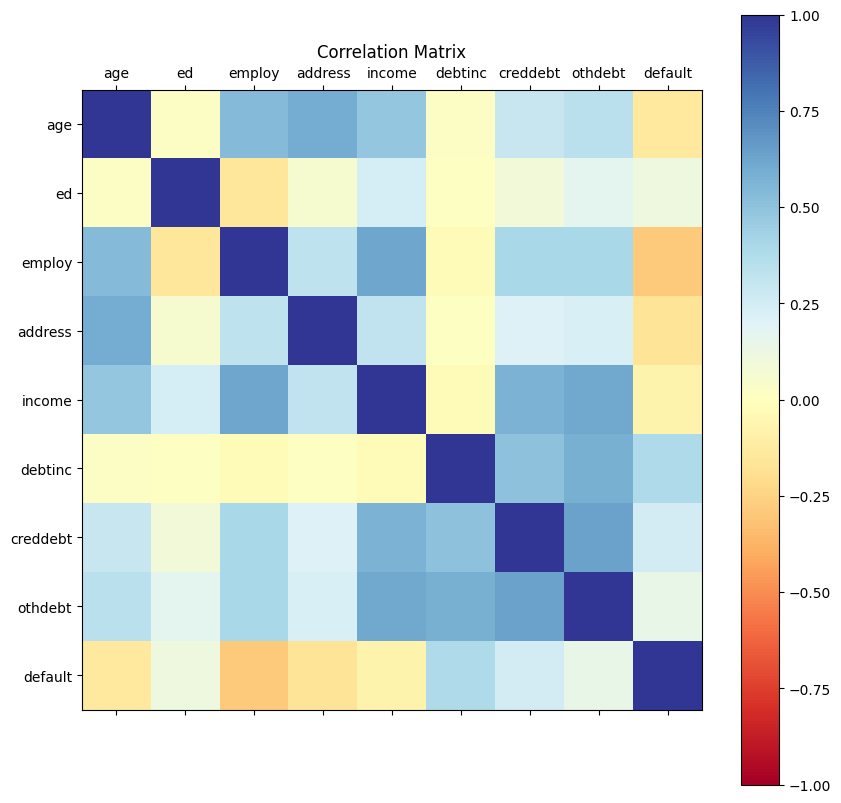

In [7]:
plot_corr(df,10)
plt.show()

### 3. Separate Training and Testing Data
In this section, we are going to separate the raw data into training and testing data. The proportion of training and testing data are 70 and 30 percent of the entire data.

In [8]:
train, test = train_test_split(df,random_state=4, test_size=0.3)

,count,mean,std,min,25%,50%,75%,max
age,490.0,34.900000,7.806465,20.000000,29.000000,34.000000,40.000000,56.00000
ed,490.0,1.746939,0.951396,1.000000,1.000000,1.000000,2.000000,5.00000
employ,490.0,8.522449,6.607341,0.000000,3.000000,7.000000,12.750000,31.00000
address,490.0,8.087755,6.624492,0.000000,3.000000,7.000000,12.000000,34.00000
income,490.0,47.648980,40.497661,14.000000,24.000000,35.000000,56.750000,446.00000
debtinc,490.0,10.020000,6.761787,0.600000,5.000000,8.350000,13.600000,41.30000
creddebt,490.0,1.532899,1.976101,0.011696,0.376884,0.852257,1.887911,16.03147
othdebt,490.0,3.088533,3.423970,0.045584,1.014664,2.010060,3.800742,27.03360
default,490.0,0.263265,0.440855,0.000000,0.000000,0.000000,1.000000,1.00000


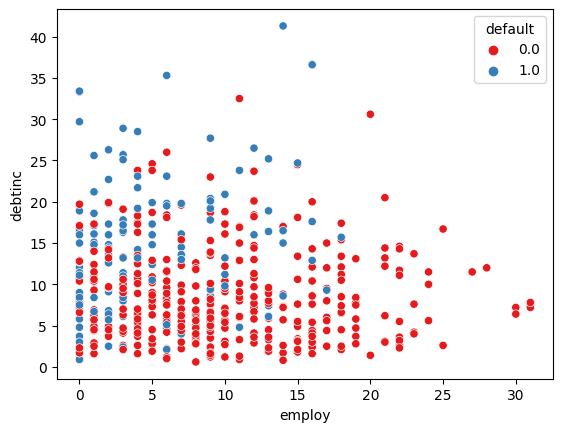

In [9]:
#Plotting the training data set
sns.scatterplot(x = 'employ', y = 'debtinc', hue='default',data=train,legend='full',palette = "Set1")
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,210.0,34.766667,8.444462,20.000000,28.000000,34.000000,40.000000,55.00000
ed,210.0,1.666667,0.871304,1.000000,1.000000,1.000000,2.000000,4.00000
employ,210.0,8.076190,6.780489,0.000000,2.000000,6.000000,12.000000,31.00000
address,210.0,8.723810,7.267935,0.000000,3.000000,7.000000,13.000000,31.00000
income,210.0,40.823810,25.743349,14.000000,24.000000,32.500000,48.500000,186.00000
debtinc,210.0,10.821905,6.961514,0.400000,5.400000,9.550000,14.700000,30.80000
creddebt,210.0,1.601744,2.419076,0.014835,0.322445,0.870258,1.960739,20.56131
othdebt,210.0,2.987451,2.951338,0.100926,1.074796,1.920880,4.137882,17.20380
default,210.0,0.257143,0.438103,0.000000,0.000000,0.000000,1.000000,1.00000


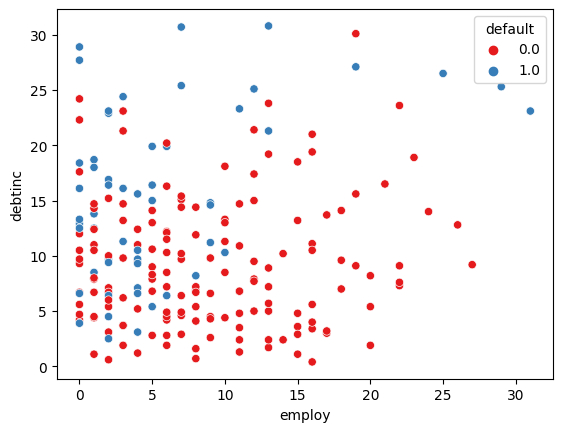

In [10]:
#Plotting the training data set
sns.scatterplot(x = 'employ', y = 'debtinc', hue='default',data=test,legend='full',palette = "Set1")
test.describe().transpose()

### 4. Normalizing Predictor Features
To remove the influence of the predictor feature's scale, we normalized the predictor features before inputting them into the support vector machines.

In [11]:
train_X = train.loc[:,['employ','debtinc']]
train_X = train_X.reset_index(drop = True)

train_y = train['default']
train_y = train_y.reset_index(drop = True)
print('The training predictor features:')
print(train_X.head())
print('\nThe training response features:')
print(train_y.head())

The training predictor features:
   employ  debtinc
0       9      8.6
1      21     13.2
2       3      2.6
3      21     20.5
4       8     12.6

The training response features:
0    1.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: default, dtype: float64


In [12]:
scaler = StandardScaler()
xx = scaler.fit_transform(train_X)
train_X['nEmploy'] = xx[:,0]
train_X['nDebtinc'] = xx[:,1]
train_X.head()

,employ,debtinc,nEmploy,nDebtinc
0,9,8.6,0.072350,-0.210218
1,21,13.2,1.890367,0.470770
2,3,2.6,-0.836659,-1.098464
3,21,20.5,1.890367,1.551470
4,8,12.6,-0.079152,0.381946


### 5. Fitting The Data to Different Kernels

#### Linear Kernel

We use the scikit-learn function $SVC$ substantiate the support vector machine:

```python
svm_linear = SVC()
```

The parameters include:

* **kernel** the kernel type that is applied to project the data to a potentially higher dimensional space
* **C** penalty for misclassification
* **random_state** random number see for random shuffling data for probability estimates

We then use the command"

```python
svm_linear.fit()
```
to train the model with the training dataset.

The parameters include:

* **X** - the $n \times m$ array with the predictor features for the training dataset 
* **y** - the $n \times 1$ array with the response feature for the training dataset 

In [13]:
C = 0.01
svm_linear = SVC(kernel = 'linear',C = C, random_state = 0)    # Create a SVC classifier using a linear kernel
svm_linear.fit(train_X.loc[:,['nEmploy','nDebtinc']], train_y)    # Train the classifier

C10 = 100
svm_linear10 = SVC(kernel = 'linear',C = C10, random_state = 0)    # Create a SVC classifier using a linear kernel
svm_linear10.fit(train_X.loc[:,['nEmploy','nDebtinc']], train_y)    # Train the classifier

SVC(C=100, kernel='linear', random_state=0)

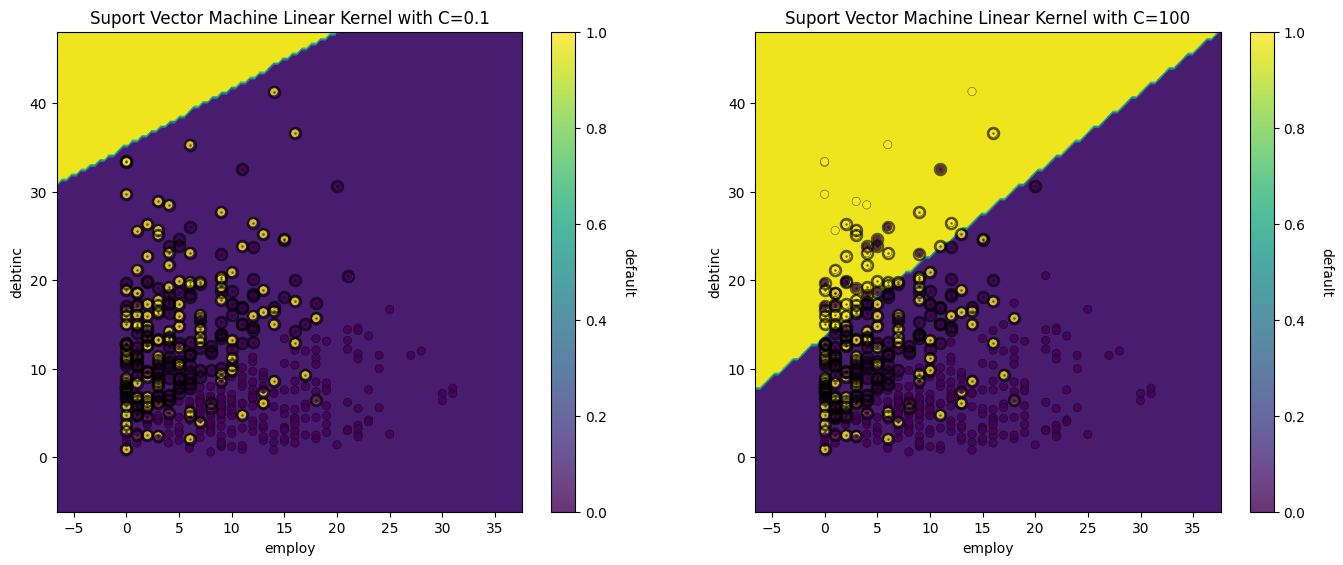

In [14]:
plt.subplot(121)
plt = visualize_model(svm_linear,train_X["nEmploy"],train_X["nDebtinc"],train_X["employ"],train_X["debtinc"],train_y)
plot_svc_decision_function(svm_linear,plt,plot_support=True)
plt.title('Suport Vector Machine Linear Kernel with C=0.1')

plt.subplot(122)
plt = visualize_model(svm_linear10,train_X["nEmploy"],train_X["nDebtinc"],train_X["employ"],train_X["debtinc"],train_y)
plot_svc_decision_function(svm_linear10,plt,plot_support=True)
plt.title('Suport Vector Machine Linear Kernel with C=100')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)

### Polynomial Kernel

The polynomial kernel is defined as

\begin{equation}
K(x,x') = (x^Tx)^d,
\end{equation}

where $d$ is the degree of polynomials.

While using the SVC function in scikit-learn package,```C```is a parameter of the SVC learner and is the penalty for misclassifying a data point. When C is smaller, the classifier is more tolerant with misclassified data points (high bias, low variance). 

```Degree``` is to control the order of the polynomial kernel function. 

In [15]:
C = 0.01
svm_poly3_C1 = SVC(kernel = 'poly', degree = 3, random_state=0,C = C)
svm_poly3_C1.fit(train_X.loc[:,['nEmploy','nDebtinc']],train_y) 

C = 0.01
svm_poly4_C1 = SVC(kernel = 'poly', degree = 5,random_state=0, C = C)
svm_poly4_C1.fit(train_X.loc[:,['nEmploy','nDebtinc']],train_y) 

C = 100
svm_poly3_C100 = SVC(kernel = 'poly', degree = 3,random_state=0, C = C)
svm_poly3_C100.fit(train_X.loc[:,['nEmploy','nDebtinc']],train_y) 

C = 100
svm_poly4_C100 = SVC(kernel = 'poly', degree = 5, random_state=0, C = C)
svm_poly4_C100.fit(train_X.loc[:,['nEmploy','nDebtinc']],train_y) 

SVC(C=100, degree=5, kernel='poly', random_state=0)

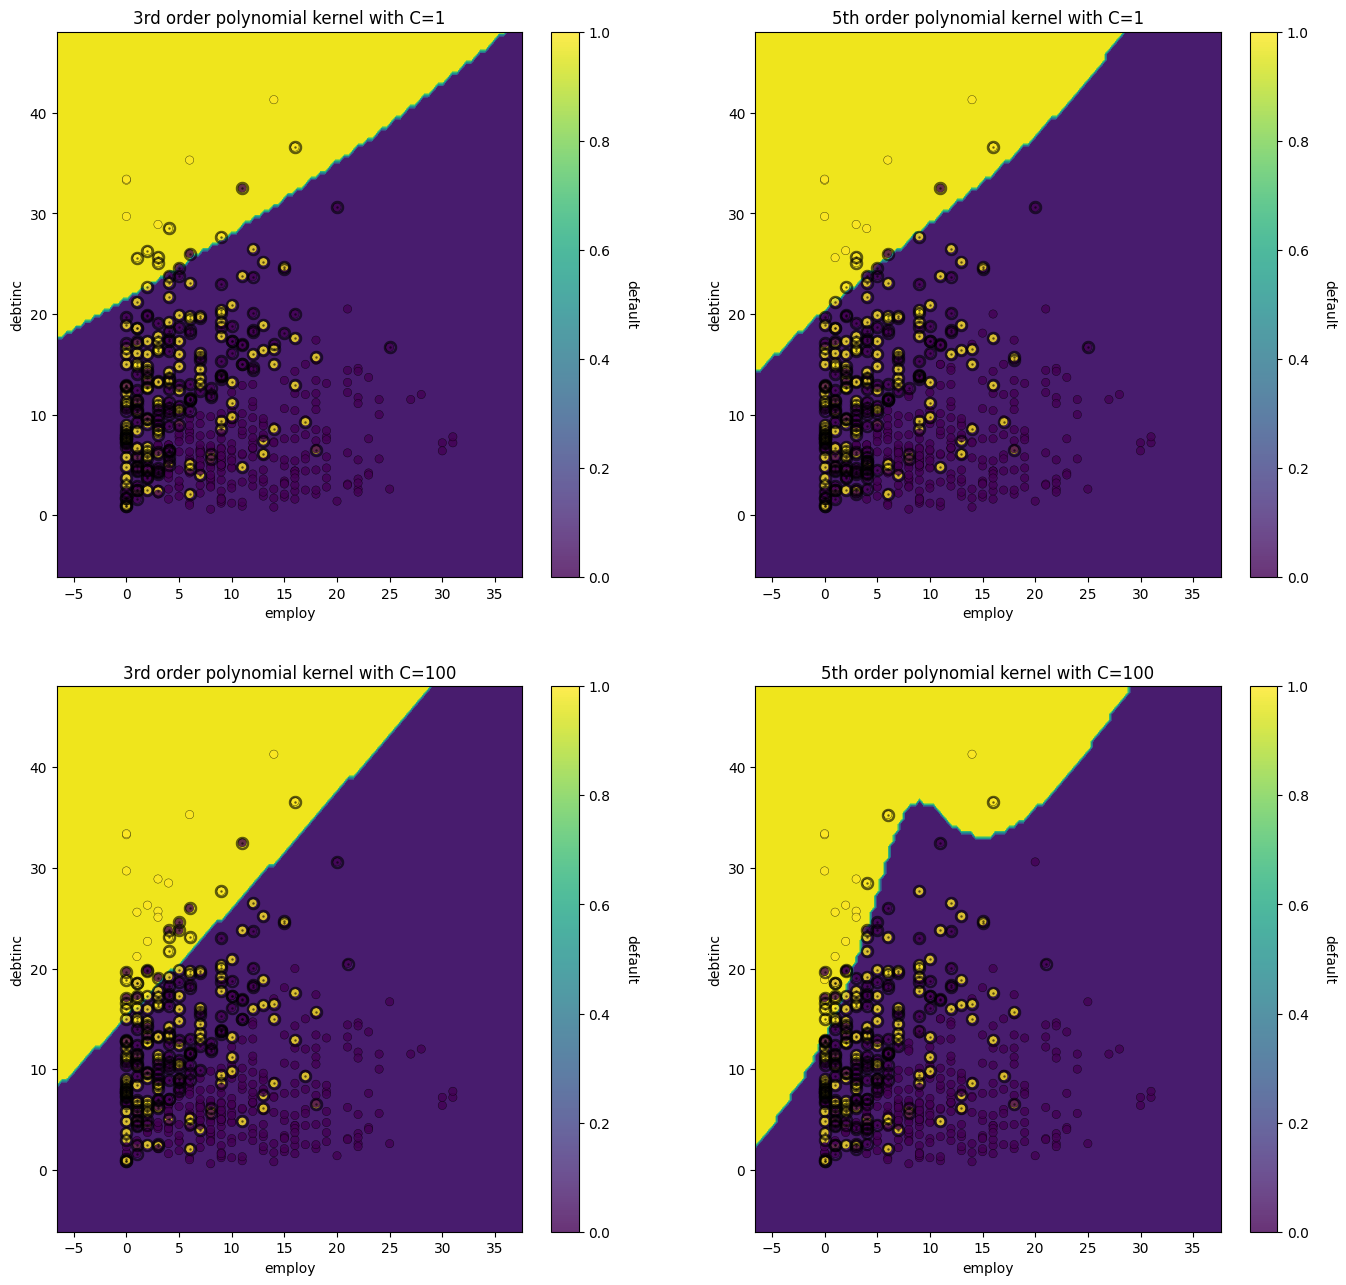

In [16]:
plt.subplot(221)
plt = visualize_model(svm_poly3_C1,train_X["nEmploy"],train_X["nDebtinc"],train_X["employ"],train_X["debtinc"],train_y)
plt.title('3rd order polynomial kernel with C=1')
plot_svc_decision_function(svm_poly3_C1,plt, plot_support=True)

plt.subplot(222)
plt = visualize_model(svm_poly4_C1,train_X["nEmploy"],train_X["nDebtinc"],train_X["employ"],train_X["debtinc"],train_y)
plt.title('5th order polynomial kernel with C=1')
plot_svc_decision_function(svm_poly4_C1,plt, plot_support=True)

plt.subplot(223)
plt = visualize_model(svm_poly3_C100,train_X["nEmploy"],train_X["nDebtinc"],train_X["employ"],train_X["debtinc"],train_y)
plt.title('3rd order polynomial kernel with C=100')
plot_svc_decision_function(svm_poly3_C100,plt, plot_support=True)

plt.subplot(224)
plt = visualize_model(svm_poly4_C100,train_X["nEmploy"],train_X["nDebtinc"],train_X["employ"],train_X["debtinc"],train_y)
plt.title('5th order polynomial kernel with C=100')
plot_svc_decision_function(svm_poly4_C100,plt, plot_support=True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)

### 6. Assessing the Impact of Kernels to Model Performance
Our data contains overlapping categories and therefore polynomial kernel is more suitable for classification than linear kernel. By using polynomial kernel, we can project the data into higher dimension and make the overlapping categories to be separable. In this section, we wanted to see how the polynomial kernel's degree (n degree) affect the model performance. To check our model performance, we used k-fold cross validation with parameter k=5. We kept the C hyperparameter value at 20.

In [17]:
#Defining variables val_X and val_Y for k-fold cross-validation
val_X = df.loc[:,['employ','debtinc']]
val_X = val_X.reset_index(drop = True)

val_y = df['default']
val_y = val_y.reset_index(drop = True)
xx = scaler.fit_transform(val_X)
val_X['nEmploy'] = xx[:,0]
val_X['nDebtinc'] = xx[:,1]
val_Y=df['default'].values

In [18]:
#WARNING this section takes a while to run
k_fold=5
Cval=20
n_degree=np.round(np.linspace(2,8,7)).astype(int) #SVM polynomial degree
k1=[]
k2=[]
k3=[]
k4=[]
k5=[]
for deg in n_degree:
    #fitting SVM Model to the data
    svm_poly = SVC(kernel = 'poly', degree = deg, random_state=0,C = Cval)
    svm_poly.fit(train_X.loc[:,['nEmploy','nDebtinc']],train_y)
    
    #k-fold cross validation
    cv_scores=cross_val_score(svm_poly,val_X.loc[:,['nEmploy','nDebtinc']],val_y)
    
    #save cross validation scores
    k1.append(cv_scores[0])
    k2.append(cv_scores[1])
    k3.append(cv_scores[2])
    k4.append(cv_scores[3])
    k5.append(cv_scores[4])
    
    print('Degree = '+str(deg)+' completed!')

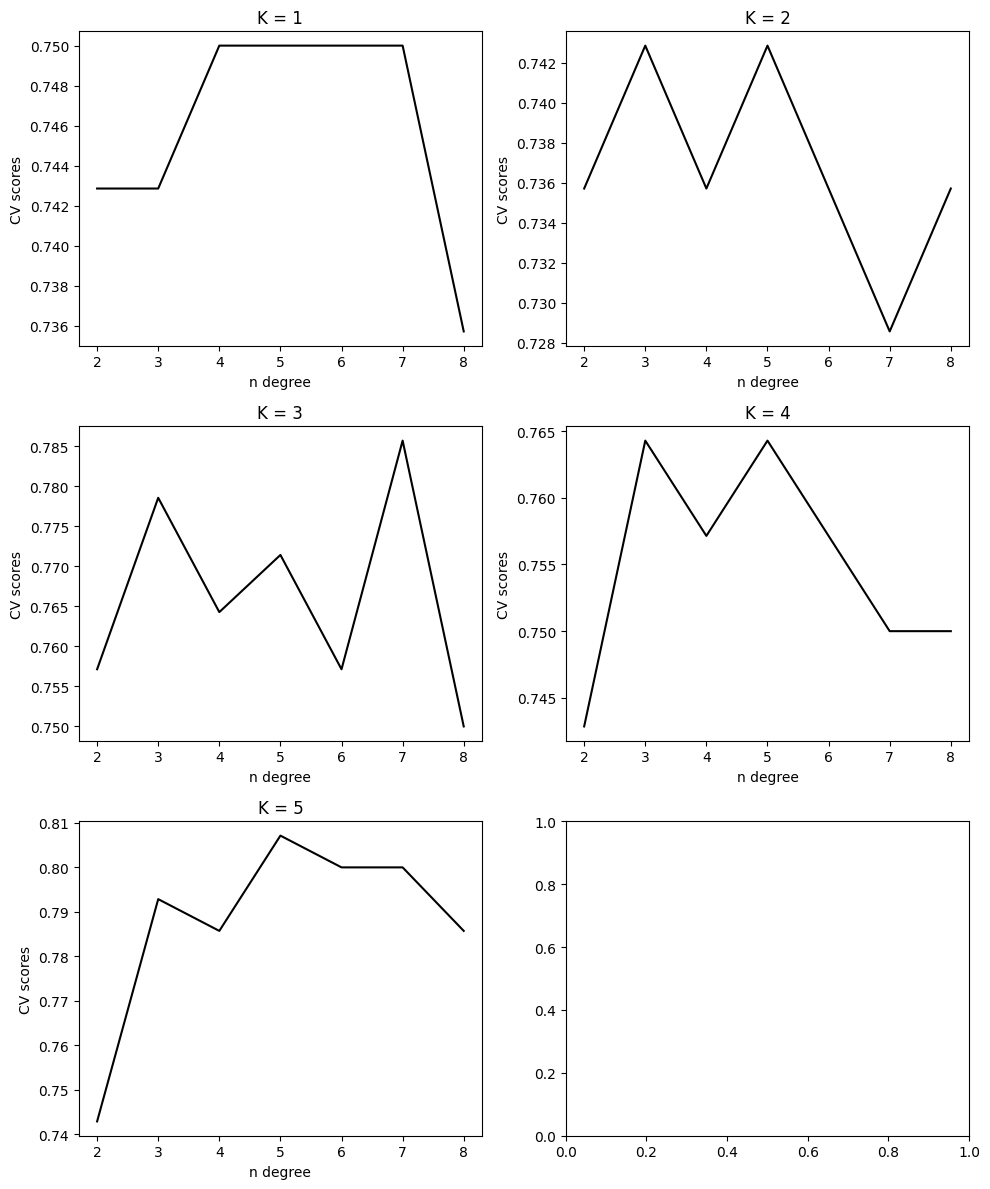

In [60]:
fig,ax=plt.subplots(3,2,figsize=(10,12))

#subplot 1
ax[0,0].plot(n_degree,k1,c='k')
ax[0,0].set_xlabel('n degree')
ax[0,0].set_ylabel('CV scores')
ax[0,0].set_title('K = 1')

#subplot 2
ax[0,1].plot(n_degree,k2,c='k')
ax[0,1].set_xlabel('n degree')
ax[0,1].set_ylabel('CV scores')
ax[0,1].set_title('K = 2')

#subplot 3
ax[1,0].plot(n_degree,k3,c='k')
ax[1,0].set_xlabel('n degree')
ax[1,0].set_ylabel('CV scores')
ax[1,0].set_title('K = 3')

#subplot 4
ax[1,1].plot(n_degree,k4,c='k')
ax[1,1].set_xlabel('n degree')
ax[1,1].set_ylabel('CV scores')
ax[1,1].set_title('K = 4')

#subplot 5
ax[2,0].plot(n_degree,k5,c='k')
ax[2,0].set_xlabel('n degree')
ax[2,0].set_ylabel('CV scores')
ax[2,0].set_title('K = 5')

fig.subplots_adjust(wspace=0.5)
fig.subplots_adjust(hspace=1)
plt.tight_layout()


### Summary of Effect of Kernel Type on the Original Linear Pattern

We can see that the optimum polynomial kernel degree is 5. The k-fold cross-validation results show that we obtain the maximum CV scores for k=1, 2, 4, 5. Additionally, we observe a reduction in CV scores when the polynomial degree, n degree, exceeds 5. This reduction may be caused by overfitting in higher-degree polynomial kernels.

___________________

### Vincent Indina, MS student, University of Texas at Austin 

Vincent is intensively conducting research on reservoir simulations of carbon capture and storage (CCS) under Dr. Kamy Sepehrnoori's supervision. He is very interested in statistics and eagerly looking for a full-time/internship position to work with the industry.




#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin